# Анализ лояльности пользователей Яндекс Афиши

- Автор: Котоломова Ксения
- Дата: 21.11.2025

### Цели и задачи проекта

<font color='#777778'>**Цель проекта:** 
    Провести исследовательский анализ заведений общественного питания в Москве и помочь в выборе подходящего места для открытия нового заведения в этом городе. 
    
**Задачи проекта:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Построить профиль каждого пользователя.
4. Провести исследовательский анализ данных:
    - изучить данные более детально;
    - изучить взаимосвязи в данных.
5. Сформулировать выводы и рекомендации по проведённому анализу.</font>

### Содержимое проекта

1. Загрузка данных и знакомство с ними.
2. Предобработка данных.
3. Создание профиля пользователя.
4. Исследовательский анализ данных.
5. Итоговый вывод и рекомендации.
---

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
!pip install psycopg2-binary

In [4]:
!pip install phik
!pip install numpy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sqlalchemy import create_engine

In [6]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [7]:
engine = create_engine(connection_string)

In [8]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT user_id,
       device_type_canonical,
       order_id,
       created_dt_msk AS order_dt,
       created_ts_msk AS order_ts,
       currency_code,
       revenue,
       tickets_count,
       created_dt_msk::date - LAG(created_dt_msk::date) OVER (PARTITION BY user_id ORDER BY created_dt_msk) AS days_since_prev,
       event_id,
       event_name_code AS event_name,
       event_type_main,
       service_name,
       region_name,
       city_name
FROM afisha.purchases AS p
JOIN afisha.events AS e USING(event_id)
LEFT JOIN afisha.city AS c USING(city_id)
LEFT JOIN afisha.regions  AS r USING(region_id)
WHERE (device_type_canonical = 'mobile' OR device_type_canonical = 'desktop') AND event_type_main != 'фильм'
ORDER BY user_id;
'''

In [9]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [11]:
display(df.head())

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


Всего в датафрейме 45 колонок и 290 611 строк с данными: два столбца с типом данных datetime64[ns], два с float64, три с int64 и восемь с object. В некоторых столбцах желательно провести корректировку типов данных, а именно: у типа данных столбцов order_id, revenue, tickets_count, days_since_prev и event_id можно понизить разрядность в целях оптимизации. Столбцы названы корректно, названия подходят для дальнейшей работы с данными. Данные соответствуют описанию. В данных присутствуют пропуски, а именно: в столбце days_since_prev.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [12]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [14]:
#Приведем дату к нужному типу для последующего объединения данных:
data['data'] = data['data'].astype('datetime64[ns]')

In [15]:
#Объединим датафреймы в один:
df = df.merge(data, how = 'inner', left_on = 'order_dt', right_on = 'data')

In [16]:
#Переводим тенге в рубли:
def convert_to_rubles(row):
    if row['currency_code'] == 'kzt':
        return row['revenue']/row['nominal'] * row['curs']
    else: 
        return row['revenue']

df['revenue_rub'] = df.apply(convert_to_rubles, axis = 1)

In [17]:
display(df.head())

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt,1521.94
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.25,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,концерты,Билеты без проблем,Боровлянский край,Каменский,2024-08-20,100,18.6972,kzt,1503.25
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.72,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,другое,Лучшие билеты,Широковская область,Радужнополье,2024-08-20,100,18.6972,kzt,39.72
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.76,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,концерты,Мой билет,Широковская область,Луговаярово,2024-08-20,100,18.6972,kzt,204.76
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.40,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,концерты,Яблоко,Травиницкий округ,Сосновечин,2024-08-20,100,18.6972,kzt,1550.40


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [19]:
#У типа данных столбцов order_id, revenue, tickets_count, days_since_prev и event_id можно понизить разрядность в целях 
#оптимизации.
df['order_id'] = pd.to_numeric(df['order_id'], downcast = 'integer')
df['revenue'] = pd.to_numeric(df['revenue'], downcast = 'float')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast = 'integer')
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast = 'float')
df['event_id'] = pd.to_numeric(df['event_id'], downcast = 'integer')

device_type_canonical
desktop     58121
mobile     232490
Name: user_id, dtype: int64

mobile     0.8
desktop    0.2
Name: device_type_canonical, dtype: float64

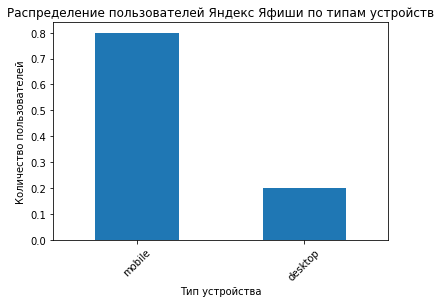

In [20]:
#Проверяем содердимое столбца device_type_canonical:
grouped_device_type = df.groupby('device_type_canonical')['user_id'].count()
display(grouped_device_type)

category_device_type = df['device_type_canonical'].value_counts(normalize = True)
display(round(category_device_type, 2))

df['device_type_canonical'].value_counts(normalize = True).plot(
    kind = 'bar', 
    x = 'device_type_canonical',
    xlabel = 'Тип устройства',
    ylabel = 'Количество пользователей',
    title = 'Распределение пользователей Яндекс Яфиши по типам устройств',
    rot = 45)

plt.show()

event_type_main
выставки      4854
другое       65867
концерты    115276
спорт        21911
стендап      13393
театр        67321
ёлки          1989
Name: user_id, dtype: int64

концерты    0.40
театр       0.23
другое      0.23
спорт       0.08
стендап     0.05
выставки    0.02
ёлки        0.01
Name: event_type_main, dtype: float64

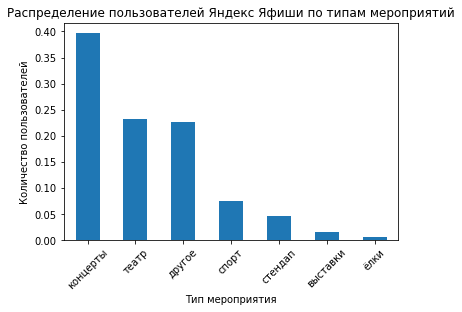

In [21]:
#Проверяем содердимое столбца event_type_main:
grouped_event_type_main = df.groupby('event_type_main')['user_id'].count()
display(grouped_event_type_main)

category_event_type_main = df['event_type_main'].value_counts(normalize = True)
display(round(category_event_type_main, 2))

df['event_type_main'].value_counts(normalize = True).plot(
    kind = 'bar', 
    x = 'event_type_main',
    xlabel = 'Тип мероприятия',
    ylabel = 'Количество пользователей',
    title = 'Распределение пользователей Яндекс Яфиши по типам мероприятий',
    rot = 45)

plt.show()

service_name
Crazy ticket!               790
Show_ticket                2200
Билет по телефону            85
Билеты без проблем        63519
Билеты в интернете            4
Билеты в руки             40343
Быстробилет                2003
Быстрый кассир              381
Весь в билетах            16849
Восьмёрка                  1118
Вперёд!                      80
Выступления.ру             1616
Городской дом культуры     2733
Дом культуры               4502
Дырокол                      74
За билетом!                2865
Зе Бест!                      5
КарандашРУ                  133
Кино билет                   67
Край билетов               6207
Лимоны                        8
Лови билет!               41124
Лучшие билеты             17774
Мир касс                   2167
Мой билет                 34839
Облачко                   26642
Прачечная                 10273
Радио ticket                376
Реестр                      125
Росбилет                    539
Тебе билет!                

Билеты без проблем        0.21857
Лови билет!               0.14151
Билеты в руки             0.13882
Мой билет                 0.11988
Облачко                   0.09168
Лучшие билеты             0.06116
Весь в билетах            0.05798
Прачечная                 0.03535
Край билетов              0.02136
Тебе билет!               0.01799
Яблоко                    0.01734
Дом культуры              0.01549
За билетом!               0.00986
Городской дом культуры    0.00940
Show_ticket               0.00757
Мир касс                  0.00746
Быстробилет               0.00689
Выступления.ру            0.00556
Восьмёрка                 0.00385
Crazy ticket!             0.00272
Росбилет                  0.00185
Шоу начинается!           0.00172
Быстрый кассир            0.00131
Радио ticket              0.00129
Телебилет                 0.00110
КарандашРУ                0.00046
Реестр                    0.00043
Билет по телефону         0.00029
Вперёд!                   0.00028
Дырокол       

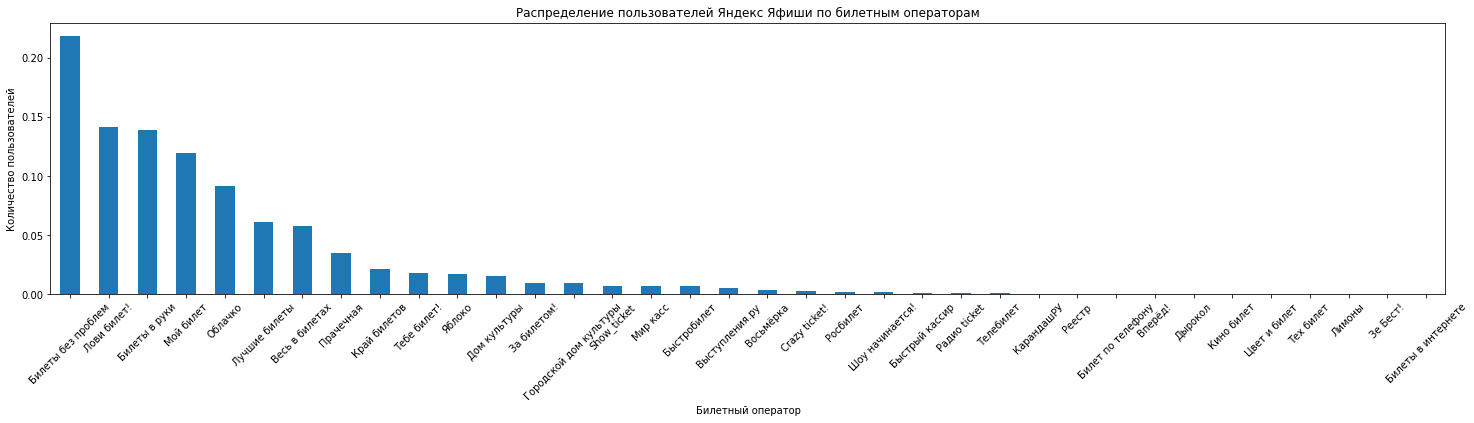

In [22]:
#Проверяем содердимое столбца service_name:
grouped_service_name = df.groupby('service_name')['user_id'].count()
display(grouped_service_name)

category_service_name = df['service_name'].value_counts(normalize = True)
display(round(category_service_name, 5))

df['service_name'].value_counts(normalize = True).plot(
    kind = 'bar', 
    x = 'service_name',
    xlabel = 'Билетный оператор',
    ylabel = 'Количество пользователей',
    title = 'Распределение пользователей Яндекс Яфиши по билетным операторам',
    figsize = (25, 5),
    rot = 45)

plt.show()

In [23]:
#Проверяем наличие явных дубликатов:
df.duplicated().sum()

0

In [24]:
#Проверяем наличие неявных дубликатов:
df.duplicated(subset = ['event_name', 'order_ts', 'city_name']).sum()

1762

In [25]:
#Проверяем наличие выбросов и аномалий:
df['revenue_rub'].describe()

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

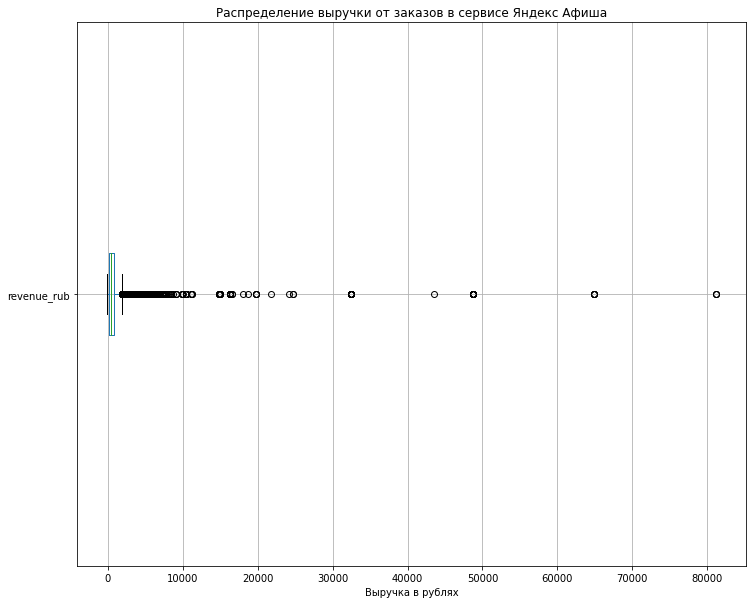

In [26]:
boxplot = df.boxplot(
    column='revenue_rub',
    vert=False,
    figsize = (12, 10))

boxplot.set_title('Распределение выручки от заказов в сервисе Яндекс Афиша')
boxplot.set_xlabel('Выручка в рублях')

plt.show()

In [27]:
df['tickets_count'].describe()

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

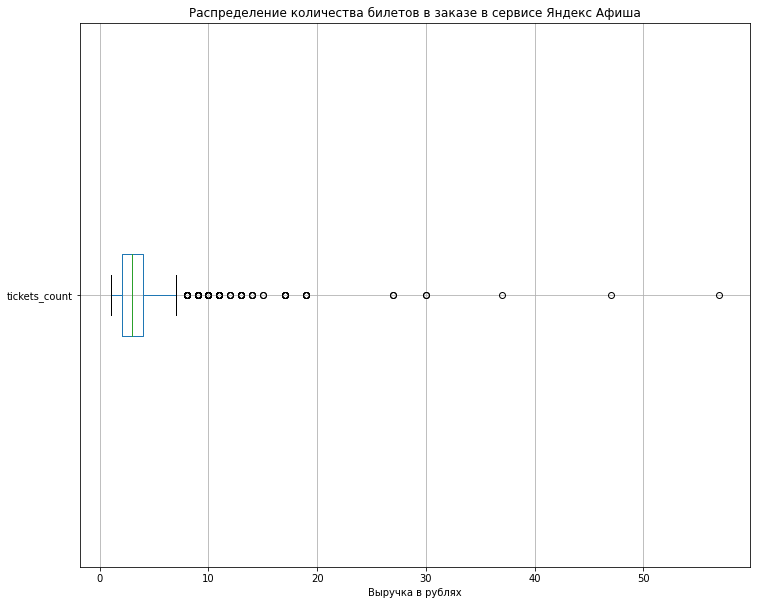

In [28]:
boxplot = df.boxplot(
    column='tickets_count',
    vert=False,
    figsize = (12, 10))

boxplot.set_title('Распределение количества билетов в заказе в сервисе Яндекс Афиша')
boxplot.set_xlabel('Выручка в рублях')

plt.show()

In [29]:
df.shape[0]

290611

In [30]:
#Отфильтруем revenue_rub по 99 перцентилю:
filtered = df['revenue_rub'].quantile(0.99)
df = df[df['revenue_rub'] < filtered]

In [31]:
df.shape[0]

287604

В типах данных нескольких столбцов была понижена разрядность. К данным были присоединены столбцы:  data (дата, на которую ориентируемся при переводе валют), nominal (номинал), curs(курс), cdx (валюта). Пропуски присутствуют только в столбце days_since_prev. Среди категорий есть такая, что обозначает пропуски в данных или отсутствие информации - это категория "другое" в столбце event_type_main, таких значений 65867. Явные дубликаты в данных отсутствуют, неявных 1762. Чаще всего сервисом пользвуются с мобильных устройств (80%). Самые популярные типы мероприятий среди пользователей Яндекс Афиши: концерты, театр, другое (40%, 23% и 23% соответственно). Наименее популярные - ёлки, выставки, стендап (1%, 2% и 5% соответственно). Наиболее популярные билетные операторы: "Билеты без проблем", "Лови билет!", "Билеты в руки". Среднее отклонение в столбце revenue_rub сильно отличается от медианы, минимальное значение в этом столбце - "-90,76", а так же прочитав график, можно сделать вывод о том, что в данных есть выбросы и аномалии. Такие же выводы можно сделать и о столбце tickets_count - Среднее отклонение в столбце revenue_rub сильно отличается от медианы, максимальное значение - 57, при медианном 3, график полностью подтверждает наличие выбросов и аномалий. Отфильтровано по 99 персентилю 3007 строк.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [32]:
df.sort_values('order_ts')
display(df.head())

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt,1521.94
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.250000,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,концерты,Билеты без проблем,Боровлянский край,Каменский,2024-08-20,100,18.6972,kzt,1503.25
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.720001,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,другое,Лучшие билеты,Широковская область,Радужнополье,2024-08-20,100,18.6972,kzt,39.72
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.759995,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,концерты,Мой билет,Широковская область,Луговаярово,2024-08-20,100,18.6972,kzt,204.76
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.400024,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,концерты,Яблоко,Травиницкий округ,Сосновечин,2024-08-20,100,18.6972,kzt,1550.40


In [33]:
#Дата первого заказа:
first_orders = df.groupby('user_id')['order_ts'].min().reset_index()
first_orders = first_orders.rename(columns = {'order_ts': 'order_ts_first'})
display(first_orders.head())

#Дата последнего заказа:
last_orders = df.groupby('user_id')['order_ts'].max().reset_index()
last_orders = last_orders.rename(columns = {'order_ts': 'order_ts_last'})
display(last_orders.head())

,user_id,order_ts_first
0,0002849b70a3ce2,2024-08-20 16:08:03
1,0005ca5e93f2cf4,2024-07-23 18:36:24
2,000898990054619,2024-07-13 19:40:48
3,00096d1f542ab2b,2024-08-15 16:48:48
4,000a55a418c128c,2024-09-29 19:39:12


,user_id,order_ts_last
0,0002849b70a3ce2,2024-08-20 16:08:03
1,0005ca5e93f2cf4,2024-10-06 13:56:02
2,000898990054619,2024-10-23 15:12:00
3,00096d1f542ab2b,2024-08-15 16:48:48
4,000a55a418c128c,2024-10-15 10:29:04


In [34]:
#Устройство, с которого был сделан первый заказ:
first_orders_device = df.groupby('user_id')['device_type_canonical'].first().reset_index()
first_orders_device = first_orders_device.rename(columns = {'device_type_canonical': 'first_orders_device'})
display(first_orders_device.head())

,user_id,first_orders_device
0,0002849b70a3ce2,mobile
1,0005ca5e93f2cf4,mobile
2,000898990054619,mobile
3,00096d1f542ab2b,desktop
4,000a55a418c128c,mobile


In [35]:
#Регион, в котором был сделан первый заказ:
first_orders_region = df.groupby('user_id')['region_name'].first().reset_index()
first_orders_region = first_orders_region.rename(columns = {'region_name': 'first_orders_region'})
display(first_orders_region.head())

,user_id,first_orders_region
0,0002849b70a3ce2,Каменевский регион
1,0005ca5e93f2cf4,Каменевский регион
2,000898990054619,Североярская область
3,00096d1f542ab2b,Каменевский регион
4,000a55a418c128c,Поленовский край


In [36]:
#Билетный партнер, к которому обращались при первом заказе:
first_orders_service = df.groupby('user_id')['service_name'].first().reset_index()
first_orders_service = first_orders_service.rename(columns = {'service_name': 'first_orders_service'})
display(first_orders_service.head())

,user_id,first_orders_service
0,0002849b70a3ce2,Край билетов
1,0005ca5e93f2cf4,Мой билет
2,000898990054619,Лови билет!
3,00096d1f542ab2b,Край билетов
4,000a55a418c128c,Лучшие билеты


In [37]:
#Жанр первого посещённого мероприятия:
first_orders_event_type = df.groupby('user_id')['event_type_main'].first().reset_index()
first_orders_event_type = first_orders_event_type.rename(columns = {'event_type_main': 'first_orders_event_type'})
display(first_orders_event_type.head())

,user_id,first_orders_event_type
0,0002849b70a3ce2,театр
1,0005ca5e93f2cf4,выставки
2,000898990054619,другое
3,00096d1f542ab2b,театр
4,000a55a418c128c,театр


In [38]:
#Общее количество заказов:
total_orders = df.groupby('user_id')['order_id'].count().reset_index()
total_orders = total_orders.rename(columns = {'order_id': 'total_orders'})
display(total_orders.head())

,user_id,total_orders
0,0002849b70a3ce2,1
1,0005ca5e93f2cf4,2
2,000898990054619,3
3,00096d1f542ab2b,1
4,000a55a418c128c,2


In [39]:
total_orders.describe()

,total_orders
count,21848.000000
mean,13.163859
std,121.624128
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,10175.000000


In [40]:
#Средняя выручка с одного заказа:
avg_revenue = round(df.groupby('user_id')['revenue_rub'].mean().reset_index(), 2)
avg_revenue = avg_revenue.rename(columns = {'revenue_rub': 'avg_revenue'})
display(avg_revenue.head())

,user_id,avg_revenue
0,0002849b70a3ce2,1521.94
1,0005ca5e93f2cf4,774.01
2,000898990054619,767.21
3,00096d1f542ab2b,917.83
4,000a55a418c128c,61.31


In [41]:
#Cреднее количество билетов в заказе:
avg_tickets_count = round(df.groupby('user_id')['tickets_count'].mean().reset_index(), 2)
avg_tickets_count = avg_tickets_count.rename(columns = {'tickets_count': 'avg_tickets_count'})
display(avg_tickets_count.head())

,user_id,avg_tickets_count
0,0002849b70a3ce2,4.00
1,0005ca5e93f2cf4,3.00
2,000898990054619,2.67
3,00096d1f542ab2b,4.00
4,000a55a418c128c,1.50


In [42]:
#Среднее время между заказами:
time_between_orders = df.dropna(subset=['days_since_prev']).groupby('user_id')['days_since_prev'].mean().reset_index()
time_between_orders = time_between_orders.rename(columns = {'days_since_prev': 'time_between_orders'})
display(time_between_orders)

,user_id,time_between_orders
0,0005ca5e93f2cf4,75.000000
1,000898990054619,51.000000
2,000a55a418c128c,16.000000
3,000cf0659a9f40f,0.083333
4,00147c9209d45d3,0.000000
...,...,...
13505,ffecf05f1f6a9c6,20.000000
13506,ffed3ff067d4f12,26.000000
13507,fff13b79bd47d7c,13.375000
13508,fff32fc9ad0f9f6,74.000000


In [43]:
#Добавим два бинарных признака:
#is_two — совершил ли пользователь 2 и более заказа;
#is_five — совершил ли пользователь 5 и более заказов.
total_orders['is_two'] = total_orders['total_orders'] >= 2
total_orders['is_five'] = total_orders['total_orders'] >= 5
        
display(total_orders.head())

,user_id,total_orders,is_two,is_five
0,0002849b70a3ce2,1,False,False
1,0005ca5e93f2cf4,2,True,False
2,000898990054619,3,True,False
3,00096d1f542ab2b,1,False,False
4,000a55a418c128c,2,True,False


In [44]:
user_profile = first_orders.merge(last_orders, how = 'left', on = 'user_id')
user_profile = user_profile.merge(first_orders_device, how = 'left', on = 'user_id')
user_profile = user_profile.merge(first_orders_region, how = 'left', on = 'user_id')
user_profile = user_profile.merge(first_orders_service, how = 'left', on = 'user_id')
user_profile = user_profile.merge(first_orders_event_type, how = 'left', on = 'user_id')
user_profile = user_profile.merge(total_orders, how = 'left', on = 'user_id')
user_profile = user_profile.merge(avg_revenue, how = 'left', on = 'user_id')
user_profile = user_profile.merge(avg_tickets_count, how = 'left', on = 'user_id')
user_profile = user_profile.merge(time_between_orders, how = 'left', on = 'user_id')

In [45]:
user_profile.head()

,user_id,order_ts_first,order_ts_last,first_orders_device,first_orders_region,first_orders_service,first_orders_event_type,total_orders,is_two,is_five,avg_revenue,avg_tickets_count,time_between_orders
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,False,False,1521.94,4.00,NaN
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,True,False,774.01,3.00,75.0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,True,False,767.21,2.67,51.0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,False,False,917.83,4.00,NaN
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,True,False,61.31,1.50,16.0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [46]:
#Общее число пользователей в выборке:
df_users = user_profile['user_id'].nunique()
display(df_users)

21848

In [47]:
#Средняя выручка с одного заказа:
df_avg_revenue = round(user_profile['avg_revenue'].mean(), 2)
display(df_avg_revenue)

543.39

In [48]:
#Доля пользователей, совершивших 2 и более заказа:
users_two = user_profile[user_profile['is_two'] == True]
users_two = users_two['user_id'].nunique()

share_of_users_two = round(users_two/df_users, 2)
display(share_of_users_two)

0.62

In [49]:
#Доля пользователей, совершивших 5 и более заказов:
users_five = user_profile[user_profile['is_five'] == True]
users_five = users_five['user_id'].nunique()

share_of_users_five = round(users_five/df_users, 2)
display(share_of_users_five)

0.29

In [50]:
#Статистические показатели по общему количеству заказов:
user_profile['total_orders'].describe()

count    21848.000000
mean        13.163859
std        121.624128
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10175.000000
Name: total_orders, dtype: float64

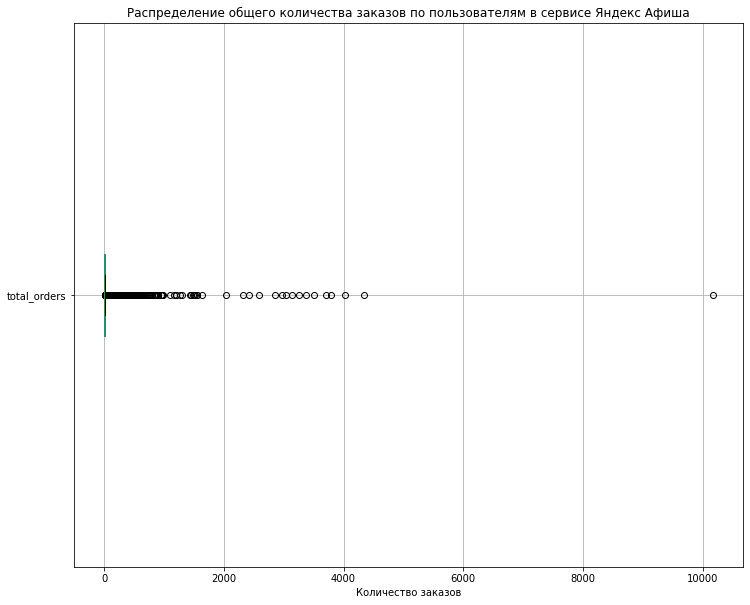

In [51]:
boxplot = user_profile.boxplot(
    column='total_orders',
    vert=False,
    figsize = (12, 10))

boxplot.set_title('Распределение общего количества заказов по пользователям в сервисе Яндекс Афиша')
boxplot.set_xlabel('Количество заказов')

plt.show()

In [52]:
#Фильтруем общее количество заказов по 99 перцентилю:
percentile_99 = user_profile['total_orders'].quantile(0.99)

filtered = user_profile[user_profile['total_orders'] < percentile_99]

filtered_orders = user_profile.shape[0] - filtered.shape[0]
display(filtered_orders)



220

In [53]:
user_profile = user_profile[user_profile['total_orders'] < percentile_99]
user_profile.shape[0]

21628

In [54]:
user_profile['avg_tickets_count'].describe()

count    21628.000000
mean         2.743119
std          0.917892
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets_count, dtype: float64

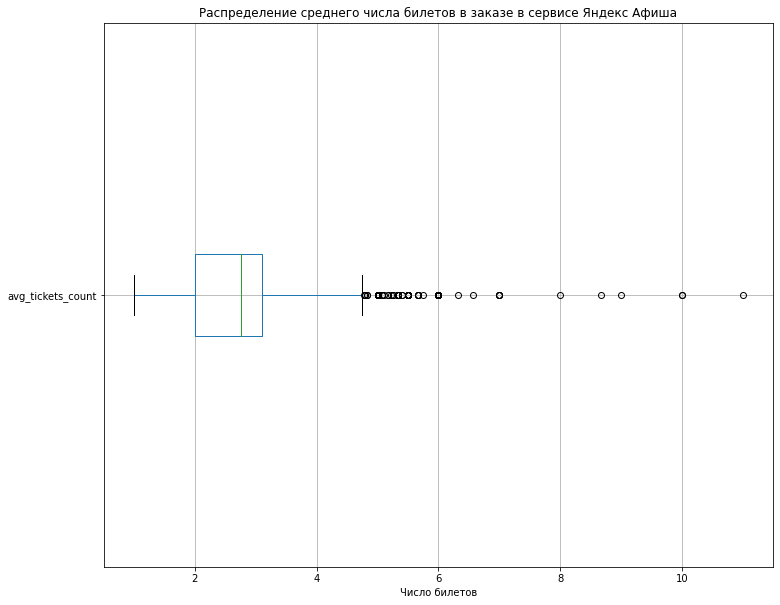

In [55]:
boxplot = user_profile.boxplot(
    column='avg_tickets_count',
    vert=False,
    figsize = (12, 10))

boxplot.set_title('Распределение среднего числа билетов в заказе в сервисе Яндекс Афиша')
boxplot.set_xlabel('Число билетов')

plt.show()

In [56]:
#Фильтруем среднее количество билетов в заказе по 99 перцентилю:
percentile_99 = user_profile['avg_tickets_count'].quantile(0.99)

filtered = user_profile[user_profile['avg_tickets_count'] < percentile_99]

filtered_orders = user_profile.shape[0] - filtered.shape[0]
display(filtered_orders)

661

In [57]:
user_profile = user_profile[user_profile['avg_tickets_count'] < percentile_99]
user_profile.shape[0]

20967

In [58]:
user_profile['time_between_orders'].describe()

count    13164.000000
mean        16.193857
std         22.418440
min          0.000000
25%          1.472610
50%          8.500000
75%         21.000000
max        148.000000
Name: time_between_orders, dtype: float64

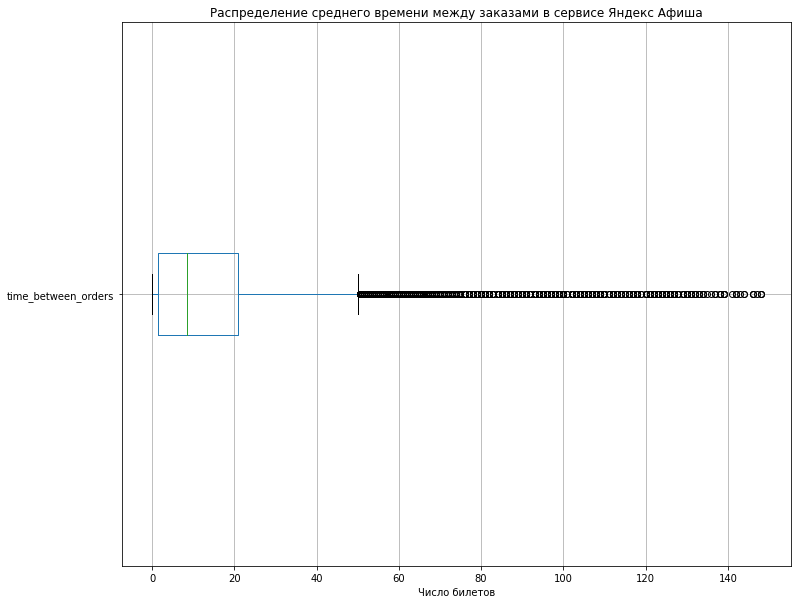

In [59]:
boxplot = user_profile.boxplot(
    column='time_between_orders',
    vert=False,
    figsize = (12, 10))

boxplot.set_title('Распределение среднего времени между заказами в сервисе Яндекс Афиша')
boxplot.set_xlabel('Число билетов')

plt.show()

В результате было рассчитано:

-Общее число пользователей в выборке (21848);
-Средняя выручка с одного заказа (543.39);
-Доля пользователей, совершивших 2 и более заказа (62%);
-Доля пользователей, совершивших 5 и более заказов (29%).

Изучены статистические показатели:

-По общему числу заказов. В данных имеются выбросы и аномалии, датафрейм отфильтрован по 99 перцентилю. Отфильтровано 220 строк;
-По среднему числу билетов в заказе. В данных так же имеются выбросы и аномалии,  датафрейм отфильтрован по 99 перцентилю по соответстсвующему столбцу. Отфильтрована 661 строка;
-По среднему количеству дней между покупками. 

Данных достаточно по объёму для дальнейшего анализа. Данные по общему числу заказов и среднему числу билетов в заказе были отфильтрованы по 99 перцентилю для того, чтобы дальшейшие исследования были более статистически верными, без явных аномалий и выбросов.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [60]:
by_first_event_type = user_profile.groupby('first_orders_event_type')['user_id'].count().sort_values(ascending = False)
print('Распределение пользователей по типу их первого мероприятия:')
display(by_first_event_type)

by_first_event_type_share = round(user_profile['first_orders_event_type'].value_counts(normalize = True), 3)
print('Доля пользователей в разрезе типа их первого мероприятия:')
display(by_first_event_type_share)

Распределение пользователей по типу их первого мероприятия:


first_orders_event_type
концерты    9106
другое      5019
театр       4313
стендап     1074
спорт        893
выставки     425
ёлки         137
Name: user_id, dtype: int64

Доля пользователей в разрезе типа их первого мероприятия:


концерты    0.434
другое      0.239
театр       0.206
стендап     0.051
спорт       0.043
выставки    0.020
ёлки        0.007
Name: first_orders_event_type, dtype: float64

In [61]:
by_first_orders_device = user_profile.groupby('first_orders_device')['user_id'].count().sort_values(ascending = False)
print('Распределение пользователей по типу устройства, с которого был соверешен первый заказ:')
display(by_first_orders_device)

by_first_orders_device_share = round(user_profile['first_orders_device'].value_counts(normalize = True), 3)
print('Доля пользователей в разрезе типа устройства, с которого был соверешен первый заказ:')
display(by_first_orders_device_share)

Распределение пользователей по типу устройства, с которого был соверешен первый заказ:


first_orders_device
mobile     17427
desktop     3540
Name: user_id, dtype: int64

Доля пользователей в разрезе типа устройства, с которого был соверешен первый заказ:


mobile     0.831
desktop    0.169
Name: first_orders_device, dtype: float64

In [62]:
by_first_orders_region = user_profile.groupby('first_orders_region')['user_id'].count().sort_values(ascending = False)
print('Распределение пользователей по региону проведения первого мероприятия:')
display(by_first_orders_region)

by_first_orders_regione_share = round(user_profile['first_orders_region'].value_counts(normalize = True), 5)
print('Доля пользователей в разрезе региона проведения первого мероприятия:')
display(by_first_orders_regione_share)

Распределение пользователей по региону проведения первого мероприятия:


first_orders_region
Каменевский регион          6675
Североярская область        3362
Широковская область         1178
Озернинский край             784
Малиновоярский округ         550
                            ... 
Залесский край                 2
Верхозёрский край              1
Светолесский край              1
Сосноводолинская область       1
Яснопольский округ             1
Name: user_id, Length: 81, dtype: int64

Доля пользователей в разрезе региона проведения первого мероприятия:


Каменевский регион          0.31836
Североярская область        0.16035
Широковская область         0.05618
Озернинский край            0.03739
Малиновоярский округ        0.02623
                             ...   
Островогорский округ        0.00010
Верхозёрский край           0.00005
Сосноводолинская область    0.00005
Яснопольский округ          0.00005
Светолесский край           0.00005
Name: first_orders_region, Length: 81, dtype: float64

In [63]:
by_first_orders_service = user_profile.groupby('first_orders_service')['user_id'].count().sort_values(ascending = False)
print('Распределение пользователей по билетному оператору, продавшему билеты на первый заказ:')
display(by_first_orders_service)

by_first_orders_service_share = round(user_profile['first_orders_service'].value_counts(normalize = True), 5)
print('Доля пользователей в разрезе билетного оператора, продавшего билеты на первый заказ:')
display(by_first_orders_service_share)

Распределение пользователей по билетному оператору, продавшему билеты на первый заказ:


first_orders_service
Билеты без проблем        4750
Лови билет!               2872
Мой билет                 2786
Билеты в руки             2412
Облачко                   2202
Весь в билетах            1270
Лучшие билеты             1255
Прачечная                  574
Край билетов               432
Яблоко                     355
Тебе билет!                352
Дом культуры               313
Городской дом культуры     215
За билетом!                212
Мир касс                   189
Быстробилет                178
Show_ticket                138
Выступления.ру             112
Восьмёрка                   72
Crazy ticket!               44
Радио ticket                36
Телебилет                   33
Шоу начинается!             33
Росбилет                    30
Быстрый кассир              21
Реестр                      15
Цвет и билет                15
КарандашРУ                  14
Кино билет                  13
Вперёд!                      9
Билет по телефону            8
Дырокол           

Доля пользователей в разрезе билетного оператора, продавшего билеты на первый заказ:


Билеты без проблем        0.22655
Лови билет!               0.13698
Мой билет                 0.13288
Билеты в руки             0.11504
Облачко                   0.10502
Весь в билетах            0.06057
Лучшие билеты             0.05986
Прачечная                 0.02738
Край билетов              0.02060
Яблоко                    0.01693
Тебе билет!               0.01679
Дом культуры              0.01493
Городской дом культуры    0.01025
За билетом!               0.01011
Мир касс                  0.00901
Быстробилет               0.00849
Show_ticket               0.00658
Выступления.ру            0.00534
Восьмёрка                 0.00343
Crazy ticket!             0.00210
Радио ticket              0.00172
Шоу начинается!           0.00157
Телебилет                 0.00157
Росбилет                  0.00143
Быстрый кассир            0.00100
Цвет и билет              0.00072
Реестр                    0.00072
КарандашРУ                0.00067
Кино билет                0.00062
Вперёд!       

Пользователи распределены по сегментам не равномерно. Присутстсвуют сегменты с наибольшим числом пользователей: это пользователи, первый заказ которых был на концерт, театр и "другое", с мобильных устройств, из Каменевского региона или Североярской области и через следующих билетных операторов: "Билеты без проблем", "Лови билет", "Мой билет".

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [64]:
print(f'Доля пользователей, совершивших два и более заказа в разрезе типа мероприятия первого заказа:')
segment_event_type_share = user_profile.groupby('first_orders_event_type').agg({'user_id': 'count', 'is_two': 'mean'}).sort_values('is_two', ascending=False).rename(columns={'user_id': 'total_users', 'is_two': 'retention_two'})
display(segment_event_type_share)

Доля пользователей, совершивших два и более заказа в разрезе типа мероприятия первого заказа:


,total_users,retention_two
first_orders_event_type,,
ёлки,137,0.729927
театр,4313,0.666358
выставки,425,0.661176
спорт,893,0.653975
стендап,1074,0.625698
концерты,9106,0.615638
другое,5019,0.602112


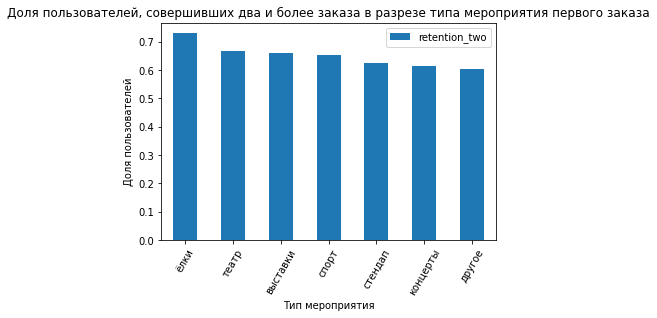

In [65]:
segment_event_type_share.plot(
    kind = 'bar',
    y = 'retention_two',
    ylabel = 'Доля пользователей',
    xlabel = 'Тип мероприятия',
    title = 'Доля пользователей, совершивших два и более заказа в разрезе типа мероприятия первого заказа',
    rot = 60)

plt.show()

In [66]:
print(f'Доля пользователей, совершивших два и более заказа в разрезе типа устройства, с которого совершен первый заказ:')
segment_device_share = user_profile.groupby('first_orders_device').agg({'user_id': 'count', 'is_two': 'mean'}).sort_values('is_two', ascending=False).rename(columns={'user_id': 'total_users', 'is_two': 'retention_two'})
display(segment_device_share)

Доля пользователей, совершивших два и более заказа в разрезе типа устройства, с которого совершен первый заказ:


,total_users,retention_two
first_orders_device,,
desktop,3540,0.650565
mobile,17427,0.621794


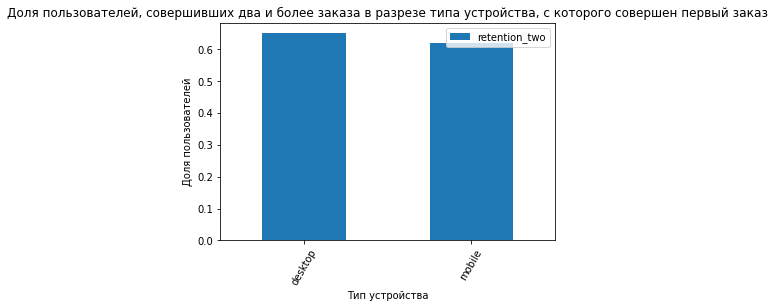

In [67]:
segment_device_share.plot(
    kind = 'bar',
    y = 'retention_two',
    ylabel = 'Доля пользователей',
    xlabel = 'Тип устройства',
    title = 'Доля пользователей, совершивших два и более заказа в разрезе типа устройства, с которого совершен первый заказ',
    rot = 60)

plt.show()

In [68]:
print(f'Доля пользователей, совершивших два и более заказа в разрезе региона первого заказ:')
segment_region_share = user_profile.groupby('first_orders_region').agg({'user_id': 'count', 'is_two': 'mean'}).sort_values('user_id', ascending=False).rename(columns={'user_id': 'total_users', 'is_two': 'retention_two'})

top_segment_region = segment_region_share.head(10)
display(top_segment_region)

Доля пользователей, совершивших два и более заказа в разрезе региона первого заказ:


,total_users,retention_two
first_orders_region,,
Каменевский регион,6675,0.627266
Североярская область,3362,0.627603
Широковская область,1178,0.662139
Озернинский край,784,0.640306
Малиновоярский округ,550,0.592727
Светополянский округ,481,0.694387
Речиновская область,441,0.655329
Яблоневская область,429,0.638695
Травяная область,419,0.570406


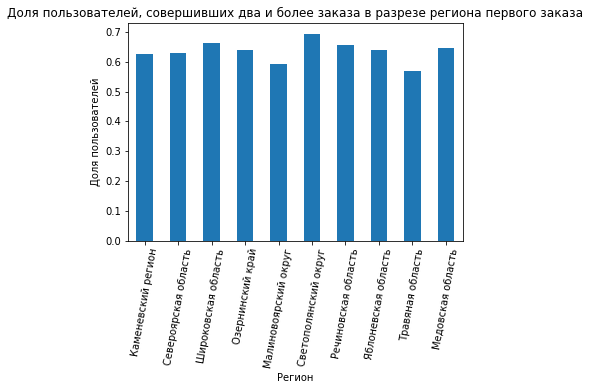

In [69]:
top_segment_region.plot(
    kind = 'bar',
    y = 'retention_two',
    ylabel = 'Доля пользователей',
    xlabel = 'Регион',
    title = 'Доля пользователей, совершивших два и более заказа в разрезе региона первого заказа',
    rot = 80,
    legend = False)

plt.show()

In [70]:
print(f'Доля пользователей, совершивших два и более заказа в разрезе билетного оператора:')
segment_service_share = user_profile.groupby('first_orders_service').agg({'user_id': 'count', 'is_two': 'mean'}).sort_values('user_id', ascending=False).rename(columns={'user_id': 'total_users', 'is_two': 'retention_two'})

top_segment_service = segment_service_share.head(10)
display(top_segment_service)

Доля пользователей, совершивших два и более заказа в разрезе билетного оператора:


,total_users,retention_two
first_orders_service,,
Билеты без проблем,4750,0.596211
Лови билет!,2872,0.644150
Мой билет,2786,0.610194
Билеты в руки,2412,0.628939
Облачко,2202,0.627611
Весь в билетах,1270,0.645669
Лучшие билеты,1255,0.666932
Прачечная,574,0.651568
Край билетов,432,0.659722


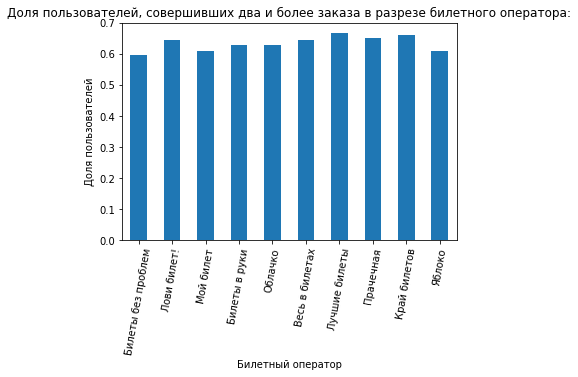

In [71]:
top_segment_service.plot(
    kind = 'bar',
    y = 'retention_two',
    ylabel = 'Доля пользователей',
    xlabel = 'Билетный оператор',
    title = 'Доля пользователей, совершивших два и более заказа в разрезе билетного оператора:',
    rot = 80,
    legend = False)

plt.show()

In [72]:
print('Средняя доля возвратов по всей выборке:')
retention = round(user_profile['is_two'].mean(), 2)
display(retention)

Средняя доля возвратов по всей выборке:


0.63

In [73]:
#Сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке:
print('Типы мероприятий с возвращаемостью выше среднего:')
segment_event_type_share_high = segment_event_type_share[segment_event_type_share['retention_two'] > retention]
display(segment_event_type_share_high)

print('Типы устройств с возвращаемостью выше среднего:')
segment_device_share_high = segment_device_share[segment_device_share['retention_two'] > retention]
display(segment_device_share_high)

print('Регионы с возвращаемостью выше среднего:')
segment_region_share_high = segment_region_share[segment_region_share['retention_two'] > retention]
display(segment_region_share_high)

print('Билетные операторы с возвращаемостью выше среднего:')
segment_service_share_high = segment_service_share[segment_service_share['retention_two'] > retention]
display(segment_service_share_high)

Типы мероприятий с возвращаемостью выше среднего:


,total_users,retention_two
first_orders_event_type,,
ёлки,137,0.729927
театр,4313,0.666358
выставки,425,0.661176
спорт,893,0.653975


Типы устройств с возвращаемостью выше среднего:


,total_users,retention_two
first_orders_device,,
desktop,3540,0.650565


Регионы с возвращаемостью выше среднего:


,total_users,retention_two
first_orders_region,,
Широковская область,1178,0.662139
Озернинский край,784,0.640306
Светополянский округ,481,0.694387
Речиновская область,441,0.655329
Яблоневская область,429,0.638695
Медовская область,395,0.645570
Солнечноземская область,326,0.684049
Солнечнореченская область,319,0.645768
Глиногорская область,273,0.630037


Билетные операторы с возвращаемостью выше среднего:


,total_users,retention_two
first_orders_service,,
Лови билет!,2872,0.644150
Весь в билетах,1270,0.645669
Лучшие билеты,1255,0.666932
Прачечная,574,0.651568
Край билетов,432,0.659722
Тебе билет!,352,0.690341
Дом культуры,313,0.642173
За билетом!,212,0.646226
Быстробилет,178,0.662921


Наибольшая доля пользователей, совершивших два и более заказа в разрезе типа мероприятия первого заказа приходится на ёлки (73%), но так как в этой категории мало пользователей и данные могут разниться, достовернее было бы сказать, что наибольшая доля пользователей, совершивших два и более заказа в разрезе типа мероприятия первого заказа приходится на театр. Доля пользователей, совершивших два и более заказа в разрезе типа устройства, с которого совершен первый заказ выше с компьютера, чем со смартфона (но разница небольшая - около 3%). Самый высокий показатель доли пользователей, совершивших два и более заказа в разрезе региона первого заказа у Светополянского округа, Широковской и Речиновской областей (69%, 66% и 64% соответственно). Самый высокий показатель доли пользователей, совершивших два и более заказа в разрезе региона первого заказа у оператора "Лучшие билеты" (67%), "Край билетов" (66%) и "Прачечная" (65%) - если брать 10 наиболее востребованных операторов среди пользователей.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [74]:
first = segment_event_type_share.sort_values('retention_two', ascending=False)
display(first)

,total_users,retention_two
first_orders_event_type,,
ёлки,137,0.729927
театр,4313,0.666358
выставки,425,0.661176
спорт,893,0.653975
стендап,1074,0.625698
концерты,9106,0.615638
другое,5019,0.602112


Гипотеза верна, так как доля вернувшихся после первой покупки пользователей, заказывавших билеты на спорт выше чем доля вернувшихся после первой покупки пользователей, заказывавших билеты на концерт (65% против 62%, но количество пользователей, первый заказ которых был на спортивное мероприятие (893) в разы меньше количества пользователей, первый заказ которых был на концерт (9106) - размер группы спортивных мероприятий значительно меньше, что делает оценку менее надежной. 

In [75]:
top_retention = top_segment_region['retention_two'].mean()
display(top_retention)
other_retention = segment_region_share['retention_two'].mean()
display(other_retention)

0.6354426628728185

0.5773417762473549

In [76]:
display(segment_region_share)

,total_users,retention_two
first_orders_region,,
Каменевский регион,6675,0.627266
Североярская область,3362,0.627603
Широковская область,1178,0.662139
Озернинский край,784,0.640306
Малиновоярский округ,550,0.592727
...,...,...
Залесский край,2,0.500000
Верхозёрский край,1,1.000000
Светолесский край,1,0.000000


Гипотеза верна, если смотреть в среднем - в топ 10 регионах по количеству пользователей средняя доля повторных заказов выше, чем в менее активных регионах.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


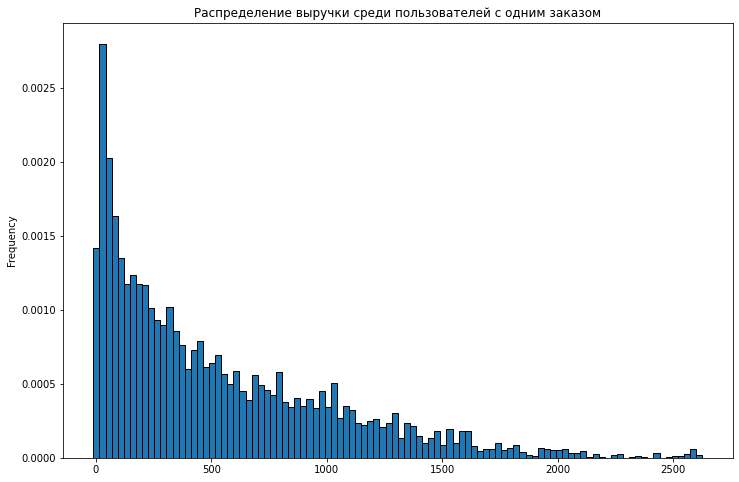

In [77]:
one_order = user_profile[user_profile['total_orders'] == 1]

one_order['avg_revenue'].plot(
    kind = 'hist',
    bins = 100,
    x = 'avg_revenue',
    xlabel = 'Выручка',
    ylabel = 'Частота',
    title = 'Распределение выручки среди пользователей с одним заказом',
    edgecolor='black',
    density=True,
    figsize=(12, 8))

plt.show()

In [78]:
one_order['avg_revenue'].describe()

count    7828.000000
mean      525.353309
std       497.036790
min       -10.770000
25%       126.030000
50%       367.610000
75%       797.940000
max      2624.810000
Name: avg_revenue, dtype: float64

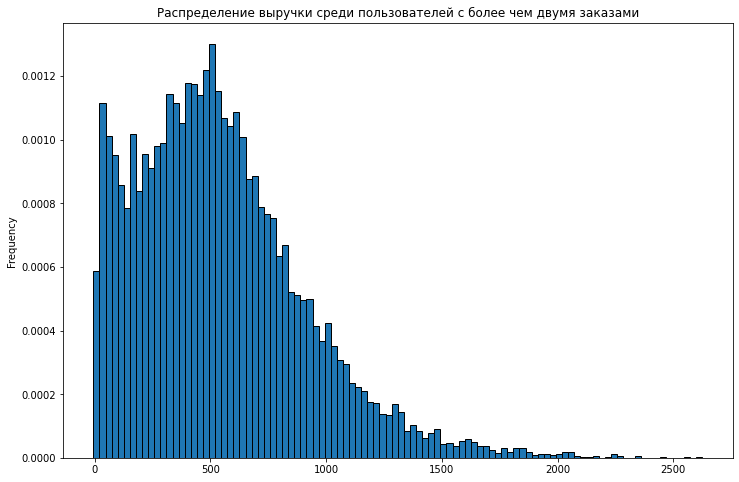

In [79]:
many_orders = user_profile[user_profile['total_orders'] >= 2]

many_orders['avg_revenue'].plot(
    kind = 'hist',
    bins = 100,
    x = 'avg_revenue',
    xlabel = 'Выручка',
    ylabel = 'Частота',
    title = 'Распределение выручки среди пользователей с более чем двумя заказами',
    edgecolor='black',
    density=True,
    figsize=(12, 8))

plt.show()

In [80]:
many_orders['avg_revenue'].describe()

count    13139.000000
mean       539.764695
std        362.160479
min         -5.380000
25%        270.120000
50%        493.890000
75%        740.030000
max       2624.810000
Name: avg_revenue, dtype: float64

Медиана выручки пользователей с одним заказом составляет 367,6, медиана выручки пользователей с двумя и более заказами составляет 493,9 - что на 34% больше. Наиболее часто встречающееся значение выручки в первой группе - от 25 до 125, во второй - от 260 до 625. По графикам наглядно видно, что выручка с одного заказа больше там, где заказов больше одного.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


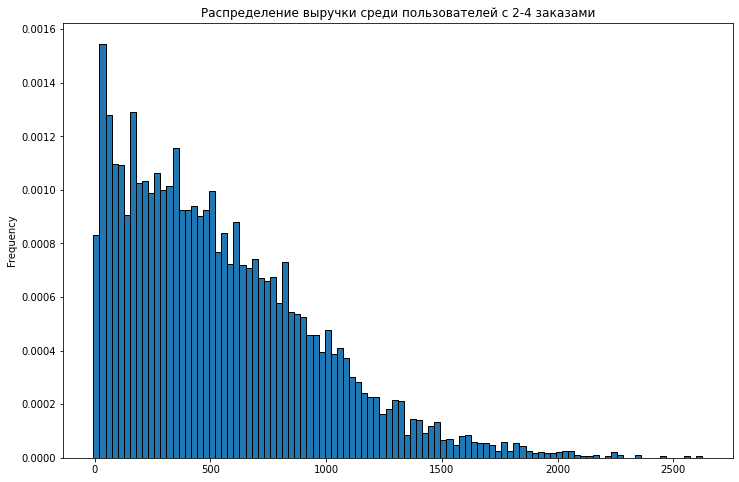

In [81]:
two_four_orders = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]

two_four_orders['avg_revenue'].plot(
    kind = 'hist',
    bins = 100,
    x = 'avg_revenue',
    xlabel = 'Выручка',
    ylabel = 'Частота',
    title = 'Распределение выручки среди пользователей с 2-4 заказами',
    edgecolor='black',
    density=True,
    figsize=(12, 8))

plt.show()

In [82]:
two_four_orders['avg_revenue'].describe()

count    7035.000000
mean      545.155448
std       411.593165
min        -5.380000
25%       217.385000
50%       467.800000
75%       792.075000
max      2624.810000
Name: avg_revenue, dtype: float64

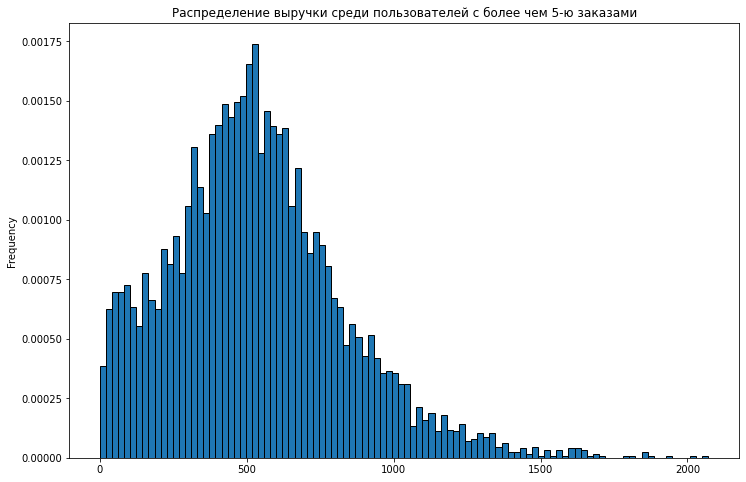

In [83]:
five_more_orders = user_profile[user_profile['total_orders'] >= 5]

five_more_orders['avg_revenue'].plot(
    kind = 'hist',
    bins = 100,
    x = 'avg_revenue',
    xlabel = 'Выручка',
    ylabel = 'Частота',
    title = 'Распределение выручки среди пользователей с более чем 5-ю заказами',
    edgecolor='black',
    density=True,
    figsize=(12, 8))

plt.show()

In [84]:
five_more_orders['avg_revenue'].describe()

count    6104.000000
mean      533.551728
std       295.001887
min         0.000000
25%       330.217500
50%       511.240000
75%       697.675000
max      2071.620000
Name: avg_revenue, dtype: float64

Медиана выручки пользователей с 2-4 заказами составляет 467,8, медиана выручки пользователей с 5 и более заказами составляет 511,2 - что на 9% больше. Наиболее часто встречающееся значение выручки в первой группе - от 25 до 350, во второй - от 300 до 550. По графикам наглядно видно, что выручка с одного заказа больше там, где заказов больше 5.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

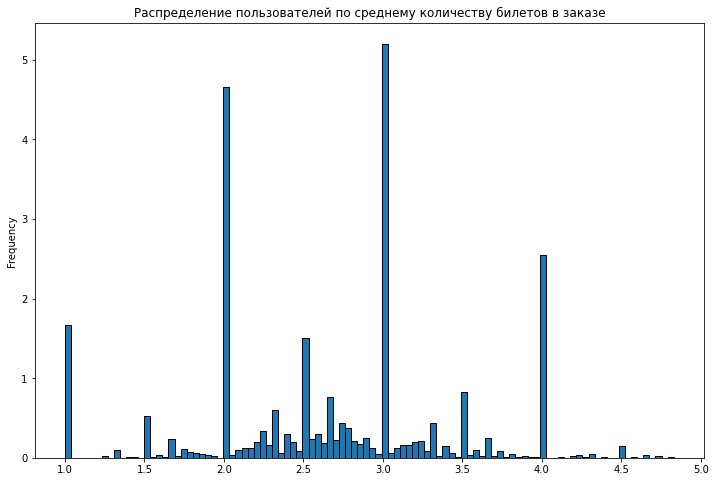

In [85]:
user_profile['avg_tickets_count'].plot(
    kind = 'hist',
    bins = 100,
    x = 'avg_tickets_count',
    xlabel = 'Среднее количество билетов в заказе',
    ylabel = 'Частота',
    title = 'Распределение пользователей по среднему количеству билетов в заказе',
    edgecolor='black',
    density=True,
    figsize=(12, 8))

plt.show()

Наиболее часто встречающееся среднее количество товаров в заказе: 1, 2, 2.5, 3, 4.

In [86]:
one_two_tickets = user_profile[(user_profile['avg_tickets_count'] > 1) & (user_profile['avg_tickets_count'] <= 2)]
one_two_tickets_users = one_two_tickets['user_id'].count()
print(f'От 1 до 2 билетов в заказе: {one_two_tickets_users}')

two_three_tickets = user_profile[(user_profile['avg_tickets_count'] > 2) & (user_profile['avg_tickets_count'] <= 3)]
two_three_tickets_users = two_three_tickets['user_id'].count()
print(f'От 2 до 3 билетов в заказе: {two_three_tickets_users}')

three_five_tickets = user_profile[(user_profile['avg_tickets_count'] > 3) & (user_profile['avg_tickets_count'] <= 5)]
three_five_tickets_users = three_five_tickets['user_id'].count()
print(f'От 3 до 5 билетов в заказе: {three_five_tickets_users}')

five_more_tickets = user_profile[user_profile['avg_tickets_count'] > 5]
five_more_tickets_users = five_more_tickets['user_id'].count()
print(f'От 5 билетов в заказе: {five_more_tickets_users}')

От 1 до 2 билетов в заказе: 4823
От 2 до 3 билетов в заказе: 9922
От 3 до 5 билетов в заказе: 4882
От 5 билетов в заказе: 0


In [87]:
one_two_tickets_many_orders = round(one_two_tickets[one_two_tickets['total_orders'] > 1]['user_id'].count() / one_two_tickets['user_id'].count(), 2)
print(f'Доля повторных покупок в сегменте пользователей от 1 до 2 билетов в заказе: {one_two_tickets_many_orders}')

two_three_tickets_many_orders = round(two_three_tickets[two_three_tickets['total_orders'] > 1]['user_id'].count() / two_three_tickets['user_id'].count(), 2)
print(f'Доля повторных покупок в сегменте пользователей от 2 до 3 билетов в заказе: {two_three_tickets_many_orders}')

three_five_tickets_many_orders = round(three_five_tickets[three_five_tickets['total_orders'] > 1]['user_id'].count() / three_five_tickets['user_id'].count(), 2)
print(f'Доля повторных покупок в сегменте пользователей от 3 до 5 билетов в заказе: {three_five_tickets_many_orders}')

Доля повторных покупок в сегменте пользователей от 1 до 2 билетов в заказе: 0.48
Доля повторных покупок в сегменте пользователей от 2 до 3 билетов в заказе: 0.74
Доля повторных покупок в сегменте пользователей от 3 до 5 билетов в заказе: 0.67


Пользователи распределены по сегментам — неравномерно. В сегменте "От 2 до 3 билетов в заказе" больше всего пользователей с повторными покупками (почти в 2 раза больше чем в сегменте "От 1 до 2 билетов в заказе" и "От 3 до 5 билетов в заказе"). Доли повторных покупок так же неравномерны, самая низкая из них в сегменте "От 1 до 2 билетов в заказе" (48%).

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [88]:
user_profile['day_of_week_first_order'] = user_profile['order_ts_first'].dt.day_of_week

In [89]:
print('Количество пользователей, совершивших первый заказ в разрезе дней недели:')
day_of_week_users = user_profile.groupby('day_of_week_first_order')['user_id'].count().reset_index()
display(day_of_week_users)

Количество пользователей, совершивших первый заказ в разрезе дней недели:


,day_of_week_first_order,user_id
0,0,2859
1,1,3057
2,2,2965
3,3,3023
4,4,3151
5,5,3221
6,6,2691


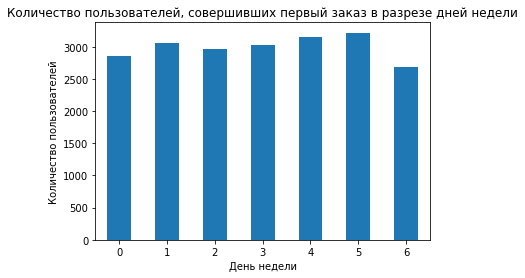

In [90]:
day_of_week_users.plot(
    kind = 'bar',
    y = 'user_id',
    ylabel = 'Количество пользователей',
    xlabel = 'День недели',
    title = 'Количество пользователей, совершивших первый заказ в разрезе дней недели',
    rot = 0,
    legend = False)

plt.show()

In [91]:
print('Доля пользователей, совершивших повторные заказы в разрезе дней недели первого заказа:')
many_orders = user_profile[user_profile['total_orders'] > 1]
day_of_week_many_orders = many_orders.groupby('day_of_week_first_order')['user_id'].count().reset_index()
day_of_week_many_orders_share = round(day_of_week_many_orders['user_id']/day_of_week_many_orders['user_id'].sum(), 2)
display(day_of_week_many_orders_share)

Доля пользователей, совершивших повторные заказы в разрезе дней недели первого заказа:


0    0.14
1    0.15
2    0.14
3    0.14
4    0.15
5    0.16
6    0.13
Name: user_id, dtype: float64

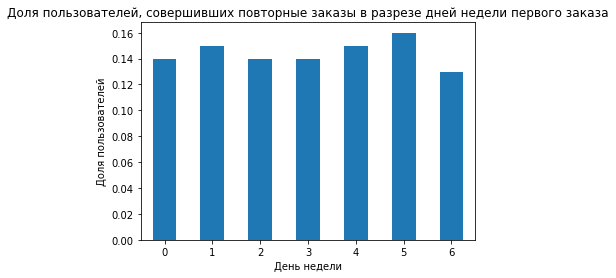

In [92]:
day_of_week_many_orders_share.plot(
    kind = 'bar',
    y = 'user_id',
    ylabel = 'Доля пользователей',
    xlabel = 'День недели',
    title = 'Доля пользователей, совершивших повторные заказы в разрезе дней недели первого заказа',
    rot = 0,
    legend = False)

plt.show()

Наибольшее количество пользователей, совершивший первый заказ в субботу (3221), чуть меньше в пятницу и вторник (3151 и 3057 соответственно). Меньше всего пользователей совершают первый заказ в воскресенье (2691, что на 16% меньше, чем в суботу).
Наибольшая доля пользователей, совершивших повторные заказы это пользователи, совершившие свой первый заказ в субботу, вторник и четверг. Наименьшая доля таких пользователей - в воскресенье. Графики похожи, из чего следует сделать вывод о том, что день недели первой покупки не влияет на повторные продажи.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [93]:
print('Среднее время между заказами пользователей, совершивших 2–4 заказа:')
two_four_orders = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
time_between_orders_2_4 = two_four_orders.groupby('user_id')['time_between_orders'].mean().reset_index()
display(time_between_orders_2_4)

Среднее время между заказами пользователей, совершивших 2–4 заказа:


,user_id,time_between_orders
0,0005ca5e93f2cf4,75.0
1,000898990054619,51.0
2,000a55a418c128c,16.0
3,00147c9209d45d3,0.0
4,001e7037d013f0f,43.5
...,...,...
7030,ffe3c623370fc5c,0.0
7031,ffe73c50cbd71fc,0.0
7032,ffecf05f1f6a9c6,20.0
7033,ffed3ff067d4f12,26.0


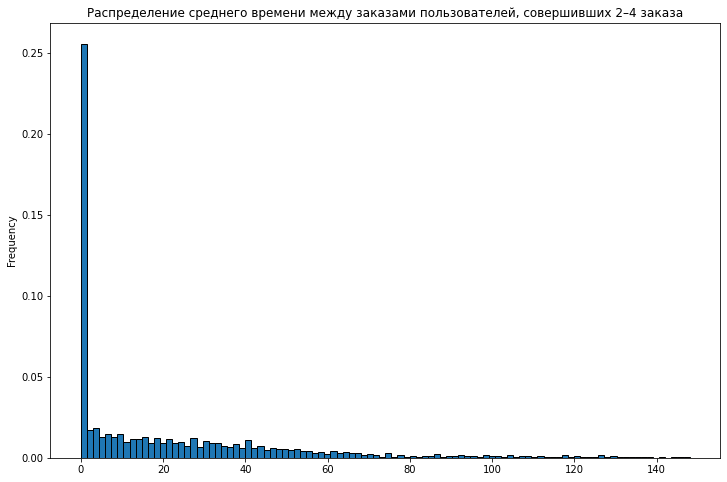

In [94]:
time_between_orders_2_4['time_between_orders'].plot(
    kind = 'hist',
    bins = 100,
    x = 'time_between_orders',
    xlabel = 'Среднее время между заказами',
    ylabel = 'Частота',
    title = 'Распределение cреднего времени между заказами пользователей, совершивших 2–4 заказа',
    edgecolor='black',
    density=True,
    figsize=(12, 8))

plt.show()

In [95]:
print('Среднее время между заказами пользователей, совершивших 5 и более заказов:')
five_more_orders = user_profile[user_profile['total_orders'] >= 5]
time_between_orders_5 = five_more_orders.groupby('user_id')['time_between_orders'].mean().reset_index()
display(time_between_orders_5)

Среднее время между заказами пользователей, совершивших 5 и более заказов:


,user_id,time_between_orders
0,000cf0659a9f40f,0.083333
1,002b75ca606ba46,20.000000
2,002ec276eee9b0b,5.380952
3,0033403583a55ed,18.000000
4,00345f897f95a34,20.428572
...,...,...
6099,ffcc69d883faddc,2.739130
6100,ffd530dc2b699b0,17.000000
6101,ffdadadd5de9c4b,9.857142
6102,fff13b79bd47d7c,13.375000


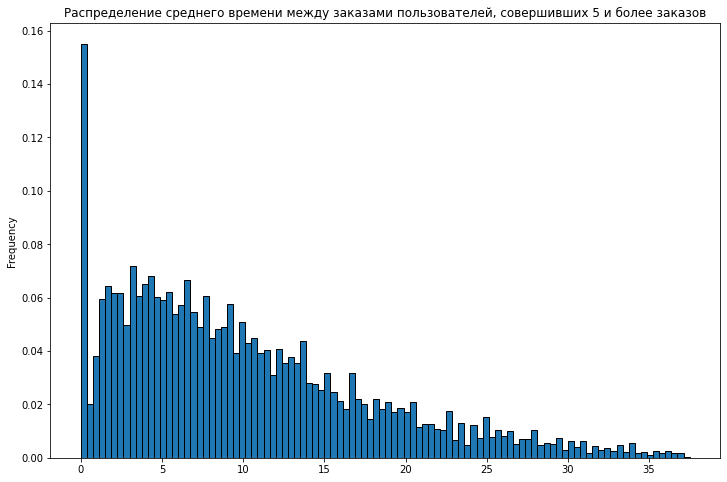

In [96]:
time_between_orders_5['time_between_orders'].plot(
    kind = 'hist',
    bins = 100,
    x = 'time_between_orders',
    xlabel = 'Среднее время между заказами',
    ylabel = 'Частота',
    title = 'Распределение cреднего времени между заказами пользователей, совершивших 5 и более заказов',
    edgecolor='black',
    density=True,
    figsize=(12, 8))

plt.show()

Большинство пользователей, совершивших 2–4 заказа, совершали повторные покупки в этот же день. Большинство пользователей, совершивших 5  и более заказов, совершали повторные покупки в этот же день, также часто встречаются значения до 10 - такие пользователи совершали повторные покупки в первые 10 дней после первого заказа.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [97]:
correlation_matrix = user_profile[['first_orders_device', 'first_orders_region', 'first_orders_service', 'first_orders_event_type', 'is_two', 'is_five', 'avg_revenue', 'avg_tickets_count', 'total_orders', 'time_between_orders', 'day_of_week_first_order']].phik_matrix(interval_cols = ['total_orders', 'time_between_orders', 'day_of_week_first_order', 'avg_revenue', 'avg_tickets_count']) 
print('Корреляционная матрица с коэффициентом phi_k для переменной total_orders')
correlation_total_orders = correlation_matrix[['total_orders']].sort_values(by='total_orders', ascending=False)
correlation_total_orders = correlation_total_orders.drop(index='total_orders')
display(correlation_total_orders)

Корреляционная матрица с коэффициентом phi_k для переменной total_orders


,total_orders
is_five,0.637079
avg_tickets_count,0.384137
is_two,0.317861
time_between_orders,0.299609
avg_revenue,0.223376
day_of_week_first_order,0.058785
first_orders_event_type,0.023229
first_orders_device,0.000000
first_orders_region,0.000000
first_orders_service,0.000000


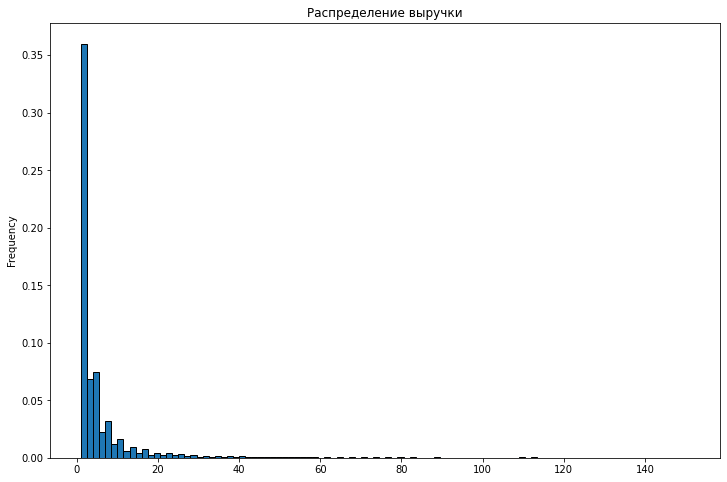

In [98]:
#Проверим разброс данных в `total_orders`:
user_profile['total_orders'].plot(
    kind = 'hist',
    bins = 100,
    x = 'total_orders',
    xlabel = 'Выручка',
    ylabel = 'Частота',
    title = 'Распределение выручки',
    edgecolor='black',
    density=True,
    figsize=(12, 8))

plt.show()

In [99]:
#В данных преобладает одно значение, поэтому построим матрицы по отдельным сегментам:
user_profile['one_order'] = (user_profile['total_orders'] == 1).astype('int') #1 заказ
user_profile['two_four_orders'] = (user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4).astype('int') #от 2 до 4 заказов
user_profile['five_more_orders'] = (user_profile['total_orders'] >= 5).astype('int') #от 5 заказов и выше

In [100]:
segments_correlation = ['first_orders_device', 'first_orders_region', 'first_orders_service', 'first_orders_event_type', 
                        'avg_revenue', 'avg_tickets_count', 'time_between_orders', 'day_of_week_first_order', 'one_order', 
                        'two_four_orders', 'five_more_orders']

correlation_matrix = user_profile[segments_correlation].phik_matrix(interval_cols=['avg_revenue', 'avg_tickets_count', 'time_between_orders', 'day_of_week_first_order'])
display(correlation_matrix)

,first_orders_device,first_orders_region,first_orders_service,first_orders_event_type,avg_revenue,avg_tickets_count,time_between_orders,day_of_week_first_order,one_order,two_four_orders,five_more_orders
first_orders_device,1.000000,0.118146,0.076569,0.057262,0.067357,0.071296,0.000000,0.038619,0.033054,0.000000,0.026914
first_orders_region,0.118146,1.000000,0.706587,0.505666,0.350450,0.108959,0.017468,0.109991,0.053286,0.035442,0.062928
first_orders_service,0.076569,0.706587,1.000000,0.636088,0.390195,0.090320,0.075368,0.056912,0.046880,0.000000,0.045274
first_orders_event_type,0.057262,0.505666,0.636088,1.000000,0.325945,0.084089,0.017316,0.054059,0.046525,0.019066,0.034165
avg_revenue,0.067357,0.350450,0.390195,0.325945,1.000000,0.473066,0.091110,0.012143,0.309402,0.062029,0.337068
avg_tickets_count,0.071296,0.108959,0.090320,0.084089,0.473066,1.000000,0.165061,0.033181,0.797751,0.488051,0.627439
time_between_orders,0.000000,0.017468,0.075368,0.017316,0.091110,0.165061,1.000000,0.000000,0.091349,0.465893,0.471142
day_of_week_first_order,0.038619,0.109991,0.056912,0.054059,0.012143,0.033181,0.000000,1.000000,0.022026,0.012723,0.026521
one_order,0.033054,0.053286,0.046880,0.046525,0.309402,0.797751,0.091349,0.022026,1.000000,0.758729,0.700979
two_four_orders,0.000000,0.035442,0.000000,0.019066,0.062029,0.488051,0.465893,0.012723,0.758729,1.000000,0.655678


In [101]:
print('Признаки, наиболее связанные с сегментом "1 заказ":')
segment_one = correlation_matrix[['one_order']].sort_values('one_order', ascending=False)
segment_one = segment_one.drop(['one_order', 'two_four_orders', 'five_more_orders'])
display(segment_one)

Признаки, наиболее связанные с сегментом "1 заказ":


,one_order
avg_tickets_count,0.797751
avg_revenue,0.309402
time_between_orders,0.091349
first_orders_region,0.053286
first_orders_service,0.046880
first_orders_event_type,0.046525
first_orders_device,0.033054
day_of_week_first_order,0.022026


In [102]:
print('Признаки, наиболее связанные с сегментом "от 2 до 4 заказов":')
segment_two_four = correlation_matrix[['two_four_orders']].sort_values('two_four_orders', ascending=False)
segment_two_four = segment_two_four.drop(['one_order', 'two_four_orders', 'five_more_orders'])
display(segment_two_four.head())

Признаки, наиболее связанные с сегментом "от 2 до 4 заказов":


,two_four_orders
avg_tickets_count,0.488051
time_between_orders,0.465893
avg_revenue,0.062029
first_orders_region,0.035442
first_orders_event_type,0.019066


In [103]:
print('Признаки, наиболее связанные с сегментом "от 5 заказов":')
segment_five_more = correlation_matrix[['five_more_orders']].sort_values('five_more_orders', ascending=False)
segment_five_more = segment_five_more.drop(['one_order', 'two_four_orders', 'five_more_orders'])
display(segment_five_more)

Признаки, наиболее связанные с сегментом "от 5 заказов":


,five_more_orders
avg_tickets_count,0.627439
time_between_orders,0.471142
avg_revenue,0.337068
first_orders_region,0.062928
first_orders_service,0.045274
first_orders_event_type,0.034165
first_orders_device,0.026914
day_of_week_first_order,0.026521


In [104]:
segments_correlation_table = pd.DataFrame()

segments_correlation_table['one_order'] = correlation_matrix['one_order'] #1 заказ
segments_correlation_table['two_four_orders'] = correlation_matrix['two_four_orders']  #2-4 заказа
segments_correlation_table['five_more_orders'] = correlation_matrix['five_more_orders']  #5 и более заказов

segments_correlation_table = segments_correlation_table.drop(['one_order', 'two_four_orders', 'five_more_orders'])
display(segments_correlation_table)

,one_order,two_four_orders,five_more_orders
first_orders_device,0.033054,0.000000,0.026914
first_orders_region,0.053286,0.035442,0.062928
first_orders_service,0.046880,0.000000,0.045274
first_orders_event_type,0.046525,0.019066,0.034165
avg_revenue,0.309402,0.062029,0.337068
avg_tickets_count,0.797751,0.488051,0.627439
time_between_orders,0.091349,0.465893,0.471142
day_of_week_first_order,0.022026,0.012723,0.026521


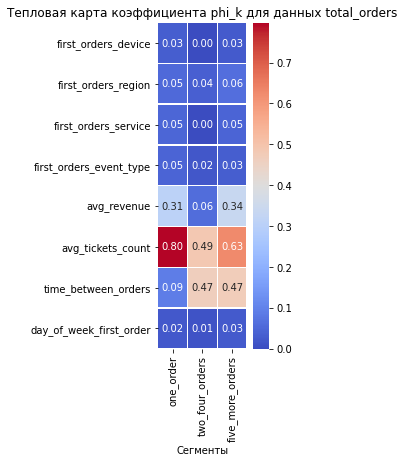

In [105]:
# Построим тепловую карту для визуализации матрицы:
plt.figure(figsize=(2, 6))

sns.heatmap(segments_correlation_table,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5,
            cbar=True)

plt.title('Тепловая карта коэффициента phi_k для данных total_orders')
plt.xlabel('Сегменты')

plt.show()

Самая высокая корреляция у сегмента "1 заказ" с количеством билетов в заказе (0.80). Также высокая корреляция с количеством билетов в заказе у сегмента "5 и более заказов". У сегмента "от 2 до 4 заказов" корреляция с этим признаком средняя. Так же наблюдается средняя корреляция сегментов "от 2 до 4 заказов" и "5 и более заказов" с признаком "время между заказами".

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Проанализированы данные о 290 611 заказах от 21 848 уникальных пользователей Яндекс Афиши за 2024 год.
Проведена предобработка данных: конвертация валют (из тенге в рубли), оптимизация типов данных, фильтрация выбросов (удалено 3 007 строк по 99-му перцентилю выручки).

Создан профиль пользователя с 15 агрегированными признаками, включая бинарные метрики возвращаемости
Ключевые результаты анализа
1. Возвращаемость пользователей:
62% пользователей совершают 2 и более заказа.
29% пользователей совершают 5 и более заказов.
Средняя выручка с заказа: 543 рубля.

2. Признаки первого заказа, влияющие на возврат:
Тип мероприятия: театр (67%), выставки (66%), спорт (65%) показывают возвращаемость выше среднего.
Устройство: пользователи с desktop (65%) возвращаются чаще, чем с mobile (62%).
Билетные операторы: "Лучшие билеты" (67%), "Край билетов" (66%), "Прачечная" (65%) демонстрируют высокую лояльность.

3. Влияние количественных показателей:
Количество билетов: пользователи, покупающие 2-3 билета за раз, имеют возвращаемость 74% (против 48% у покупателей 1-2 билетов).
Выручка: медианная выручка лояльных пользователей на 34% выше, чем у однозаказников.
Время между заказами: самые лояльные пользователи совершают повторные покупки в первые 10 дней.

4. Наиболее значимые признаки (по корреляционному анализу):
Количество билетов в заказе (корреляция 0.63-0.80).
Время между заказами (корреляция 0.47).
Средняя выручка (корреляция 0.34).

Посетители театров, выставок и спортивных мероприятий - наиболее лояльная аудитория.
Desktop-пользователи - демонстрируют более высокую вовлеченность.

Рекомендации:
Программы лояльности для пользователей, покупающих 2+ билета - можно предлагать скидки на следующий заказ. Таргетированные рассылки в первые 10 дней после заказа, так как это критическое окно для возврата. Усилить партнерство с операторами "Лучшие билеты", "Край билетов" и "Прачечная" - показывают лучшую конверсию в повторные заказы. Стимулировать групповые покупки - пользователи, покупающие несколько билетов, становятся более лояльными.

Также важно обратить внимание на пользователей с 1-2 билетами в заказе (возвращаемость всего 48%) - можно подумать в сторону дополнительной мотивации.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**